In [1]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from collections import Counter

# Data Exploration (EDA)

In [2]:
df = pd.read_csv('bank-additional-full.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(41188, 21)

In [4]:
#  Find missing values of each feature in the data set.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
df.describe().astype(np.int64)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
mean,40,258,2,962,0,0,93,-40,3,5167
std,10,259,2,186,0,1,0,4,1,72
min,17,0,1,0,0,-3,92,-50,0,4963
25%,32,102,1,999,0,-1,93,-42,1,5099
50%,38,180,2,999,0,1,93,-41,4,5191
75%,47,319,3,999,0,1,93,-36,4,5228
max,98,4918,56,999,7,1,94,-26,5,5228


## 1.Visualize distributions of numerical features with histograms¶

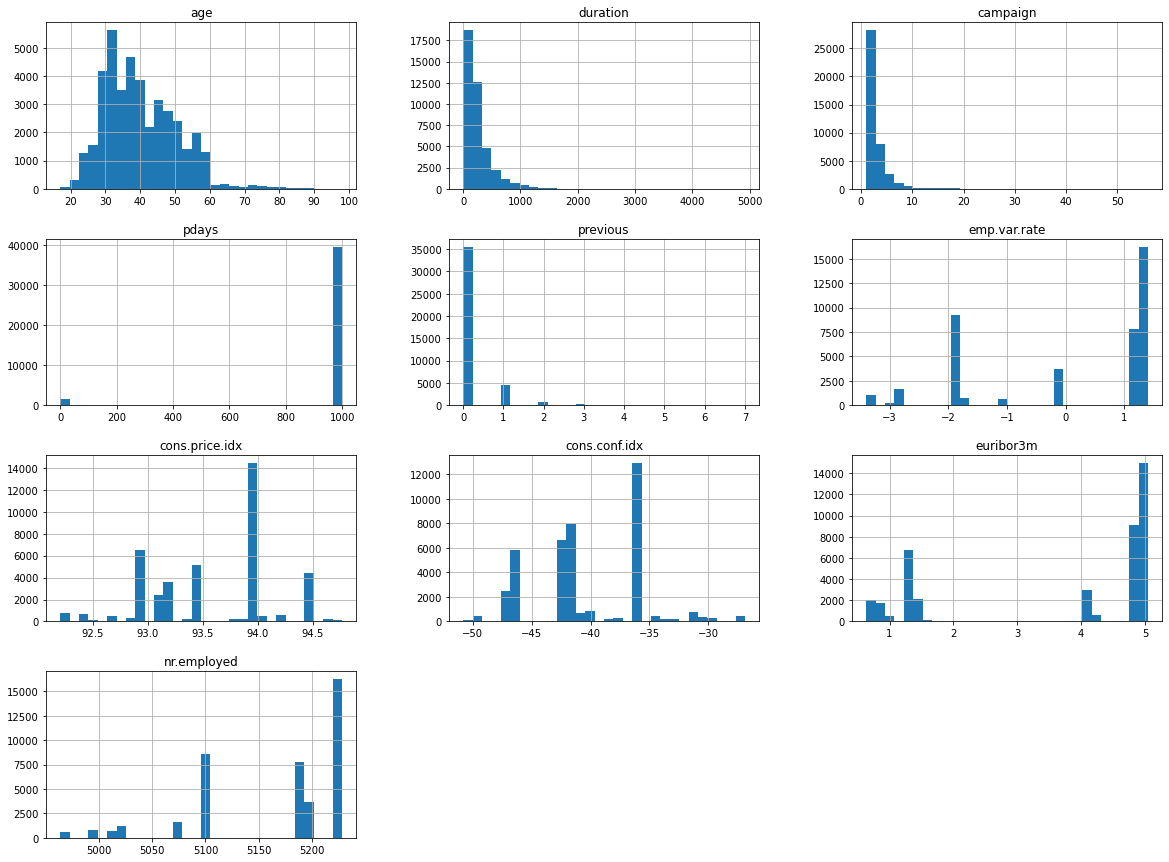

In [6]:
%matplotlib inline
df[['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']].hist(bins=30, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

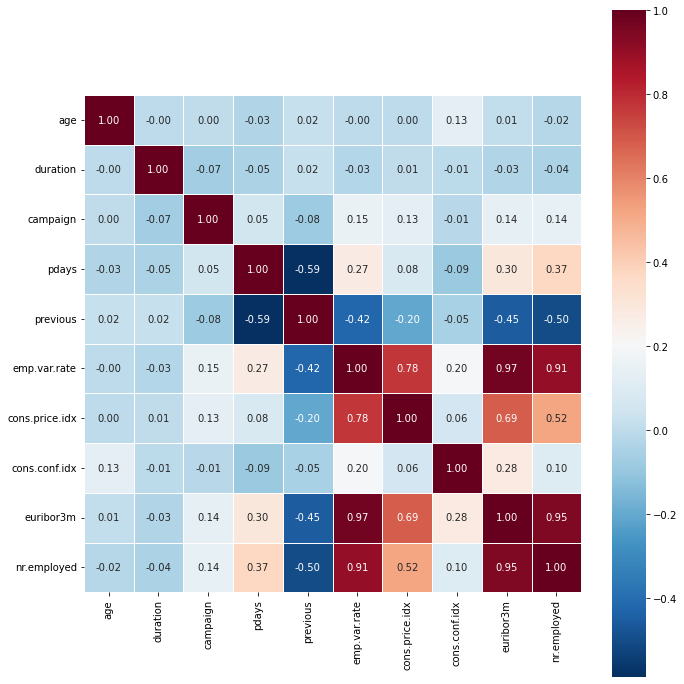

In [7]:
# Visualize feature correlations
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(df._get_numeric_data().astype(float).corr(),
            square=True, cmap='RdBu_r', linewidths=.5,
            annot=True, fmt='.2f').figure.tight_layout()
plt.show()

## 2. Category Data Distribution Visualization

In [8]:
category_features = df.select_dtypes(include=['object', 'bool']).columns.values

for col in category_features:
    print(col, "(", len(df[col].unique()) , "values):\n", np.sort(df[col].unique()))

job ( 12 values):
 ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
marital ( 4 values):
 ['divorced' 'married' 'single' 'unknown']
education ( 8 values):
 ['basic.4y' 'basic.6y' 'basic.9y' 'high.school' 'illiterate'
 'professional.course' 'university.degree' 'unknown']
default ( 3 values):
 ['no' 'unknown' 'yes']
housing ( 3 values):
 ['no' 'unknown' 'yes']
loan ( 3 values):
 ['no' 'unknown' 'yes']
contact ( 2 values):
 ['cellular' 'telephone']
month ( 10 values):
 ['apr' 'aug' 'dec' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
day_of_week ( 5 values):
 ['fri' 'mon' 'thu' 'tue' 'wed']
poutcome ( 3 values):
 ['failure' 'nonexistent' 'success']
y ( 2 values):
 ['no' 'yes']


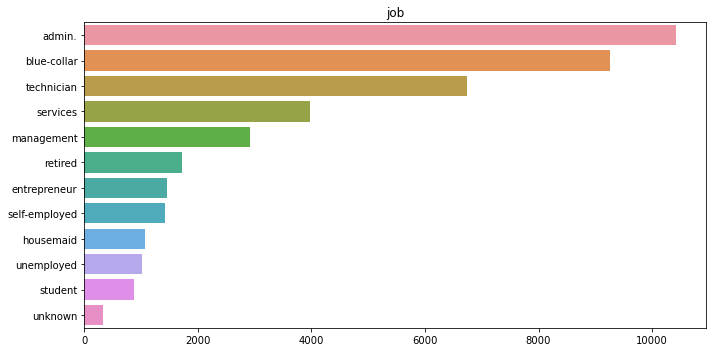

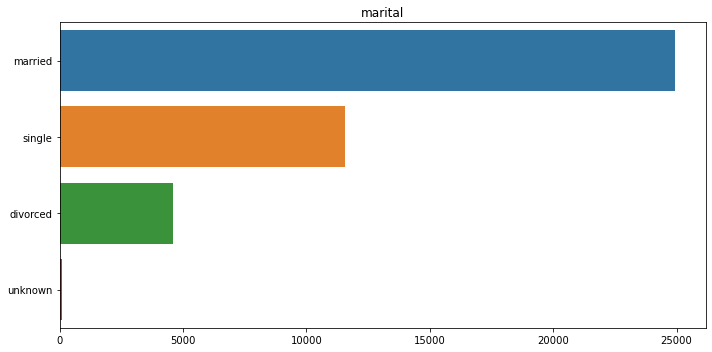

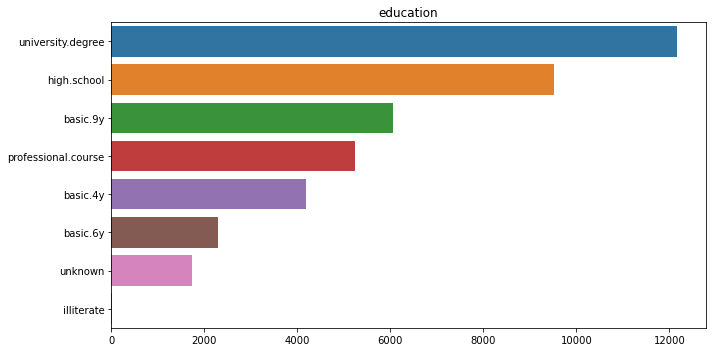

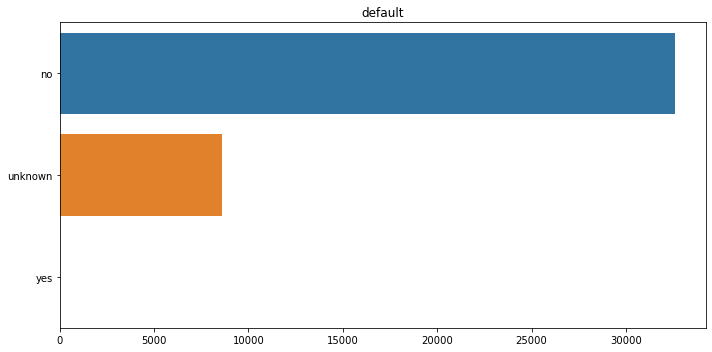

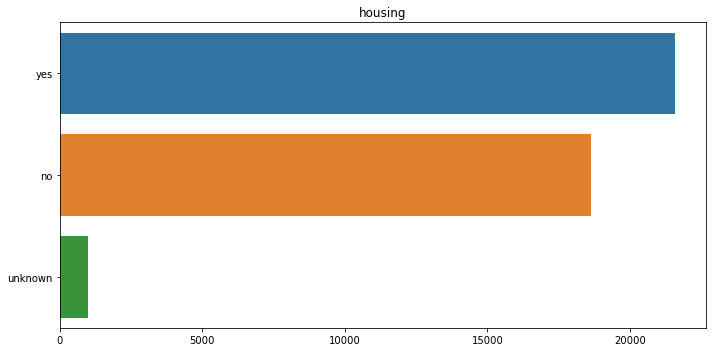

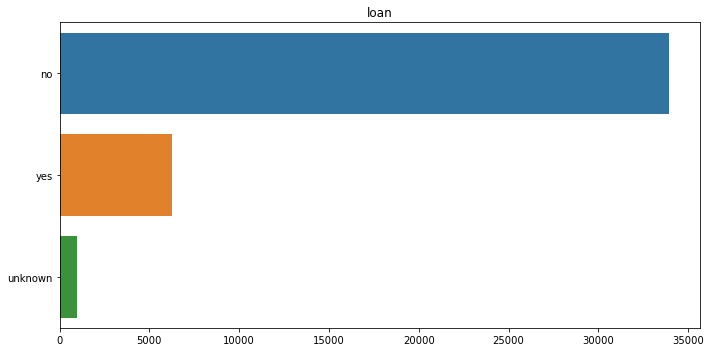

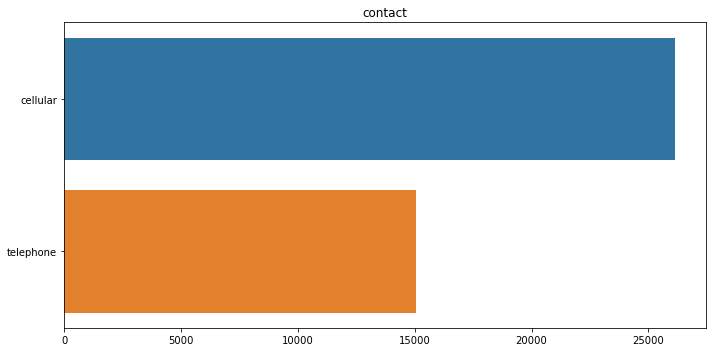

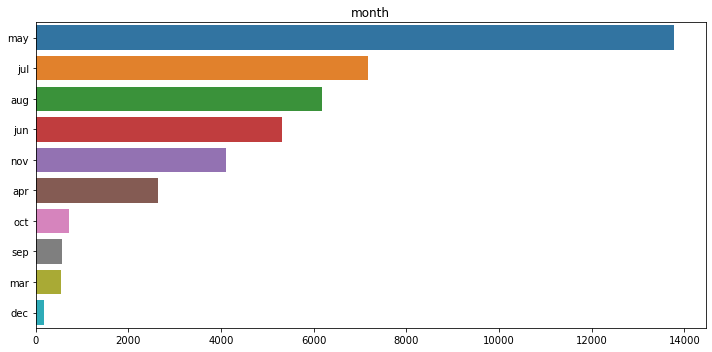

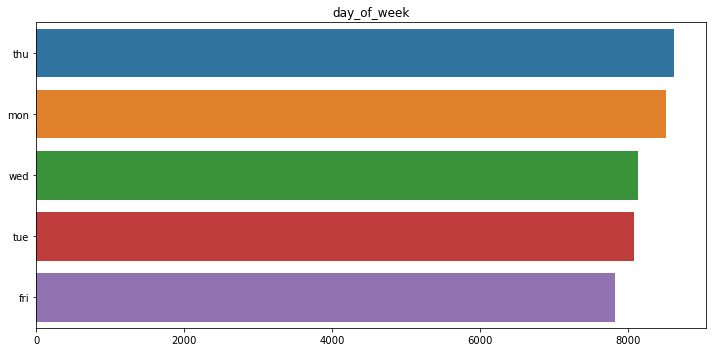

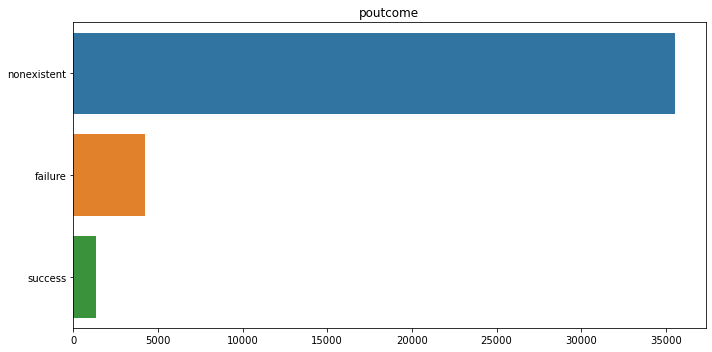

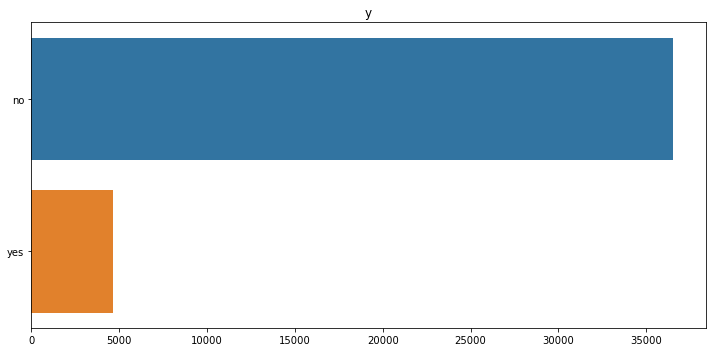

In [9]:
for col in category_features:
    plt.figure(figsize=(10,5))    
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index, data=df)    
    plt.title(col)    
    plt.tight_layout()

# Preprocessing

### Convert Categorical Variables

In [10]:
# Make a copy for parsing
df_data = df.copy()

#### --------- Job ----------

In [11]:
# Explore People who made a deposit Vs Job category
jobs = ['management','blue-collar','technician','admin.','services','retired','self-employed','student',\
        'unemployed','entrepreneur','housemaid','unknown']

for j in jobs:
    print("{:15} : {:5}". format(j, len(df_data[(df_data.y == "yes") & (df_data.job ==j)])))

management      :   328
blue-collar     :   638
technician      :   730
admin.          :  1352
services        :   323
retired         :   434
self-employed   :   149
student         :   275
unemployed      :   144
entrepreneur    :   124
housemaid       :   106
unknown         :    37


In [12]:
# Different types of job categories and their counts
df_data.job.value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [13]:
# Combine similar jobs into categiroes
df_data['job'] = df_data['job'].replace(['management', 'admin.'], 'white-collar')
df_data['job'] = df_data['job'].replace(['blue-collar', 'technician'], 'blue-collar')
df_data['job'] = df_data['job'].replace(['services','housemaid'], 'pink-collar')
df_data['job'] = df_data['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')
df_data['job'] = df_data['job'].replace(['self-employed', 'entrepreneur'], 'self-employed')

In [14]:
# New value counts
df_data.job.value_counts()

blue-collar      15997
white-collar     13346
pink-collar       5029
other             3939
self-employed     2877
Name: job, dtype: int64

In [15]:
# pdays
df['pday'] = df['pdays'] == 999
df.loc[df['pdays'] == 999, 'pdays'] = 0

In [16]:
# values for "y" : yes/no
df_data["y"] = df_data['y'].map({'yes':1, 'no':0})


In [17]:
# Drop 'duration', as every participant has been contacted. 
df_data.drop('duration', axis=1, inplace=True)

In [18]:
df_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [19]:
# Convert categorical variables to dummies
df_with_dummies = pd.get_dummies(data=df_data, columns = ['job', 'marital', 'education', 'default','housing','loan','poutcome','contact', 'month', 'day_of_week'], \
                                   prefix = ['job', 'marital', 'education', 'default','housing','loan','poutcome','contact', 'month', 'day_of_week'])
df_with_dummies.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,1,0,0,0,0,1,0,0,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,1,0,0,0,0,1,0,0,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,1,0,0,0,0,1,0,0,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,1,0,0,0,0,1,0,0,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,1,0,0,0,0,1,0,0,0


In [20]:
df_with_dummies.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654,...,0.013256,0.334296,0.099568,0.017432,0.013839,0.190031,0.206711,0.209357,0.196416,0.197485
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173,...,0.114372,0.471750,0.299427,0.130877,0.116824,0.392330,0.404951,0.406855,0.397292,0.398106
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Imbalance Data

In [21]:
# load X and y
X = df_with_dummies.drop(columns=['y'])
y = df_with_dummies['y']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)


In [22]:

from imblearn.over_sampling import SMOTE

# summarize class distribution
counter = Counter(y_train)
print(counter)

# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train)
#print(counter)


Counter({0: 27416, 1: 3475})


In [23]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [24]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Classification

## Decision Tree

[[8187  945]
 [ 778  387]]
83.0


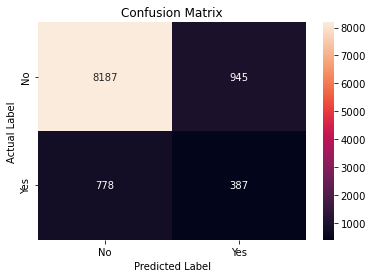

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      9132
           1       0.29      0.33      0.31      1165

    accuracy                           0.83     10297
   macro avg       0.60      0.61      0.61     10297
weighted avg       0.84      0.83      0.84     10297



In [26]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='gini') #criterion = entopy, gini
tree=dtree.fit(X_train, y_train)
#dtreepred = dtree.predict(X_test)

dtreepred = dtree.predict_proba(X_test)
cutoff = 0.5
dtreepred = dtreepred[:,1] > cutoff

print(confusion_matrix(y_test, dtreepred))
print(round(accuracy_score(y_test, dtreepred),2)*100)
DTREECV = (cross_val_score(dtree, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
import matplotlib.pyplot as plt
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(confusion_matrix(y_test, dtreepred), index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

from sklearn.metrics import classification_report
# Classification report
print(classification_report(y_test,dtreepred))

0.34914268446149477


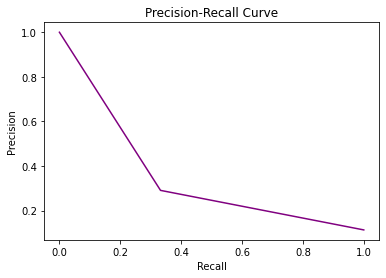

In [27]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, dtreepred)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

#display plot
plt.show()

## Random Forest

[[8718  414]
 [ 771  394]]
88.0


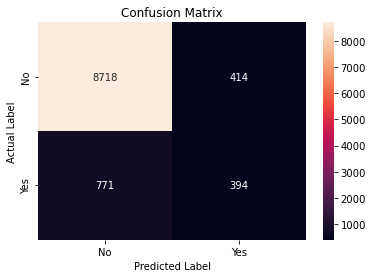

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      9132
           1       0.49      0.34      0.40      1165

    accuracy                           0.88     10297
   macro avg       0.70      0.65      0.67     10297
weighted avg       0.87      0.88      0.88     10297



In [28]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 200)#criterion = entopy,gini
result=rfc.fit(X_train, y_train)
#rfcpred = rfc.predict(X_test)
rfcpred = rfc.predict_proba(X_test)
cutoff = 0.5
rfcpred = rfcpred[:,1] > cutoff

print(confusion_matrix(y_test, rfcpred ))
print(round(accuracy_score(y_test, rfcpred),2)*100)
RFCCV = (cross_val_score(rfc, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
import matplotlib.pyplot as plt
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(confusion_matrix(y_test, rfcpred), index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

from sklearn.metrics import classification_report
# Classification report
print(classification_report(y_test,rfcpred))

0.4503486823981883


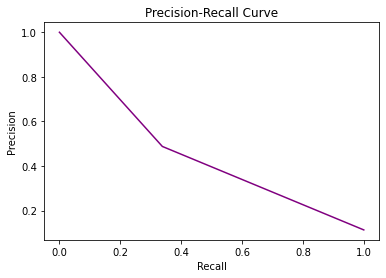

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, rfcpred)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

#display plot
plt.show()

## Logistic Regression

[[8914  218]
 [ 854  311]]
90.0


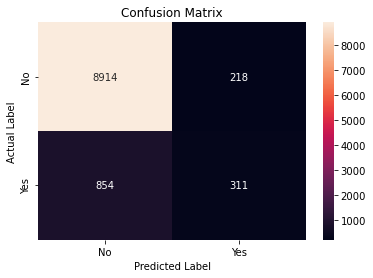

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9132
           1       0.59      0.27      0.37      1165

    accuracy                           0.90     10297
   macro avg       0.75      0.62      0.66     10297
weighted avg       0.88      0.90      0.88     10297



In [60]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
result=logmodel.fit(X_train,y_train)
#logpred = logmodel.predict(X_test)
logpred = logmodel.predict_proba(X_test)
cutoff = 0.4
logpred = logpred[:,1] > cutoff

print(confusion_matrix(y_test, logpred))
print(round(accuracy_score(y_test, logpred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
import matplotlib.pyplot as plt
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(confusion_matrix(y_test, logpred), index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

from sklearn.metrics import classification_report
# Classification report
print(classification_report(y_test,logpred))

0.4688956343625328


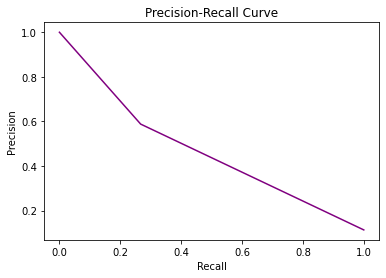

In [61]:
from sklearn.metrics import precision_recall_curve,auc
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, logpred)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

#display plot
plt.show()

In [32]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

         Current function value: 0.275834
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41143
Method:                           MLE   Df Model:                           44
Date:                Sat, 11 Jun 2022   Pseudo R-squ.:                  0.2164
Time:                        15:55:26   Log-Likelihood:                -11361.
converged:                      False   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.0015      0.002      0.816      0.415      -0.002       0.005
campaign

/Users/minghaoouyang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
from sklearn.metrics import precision_recall_curve

y_pred = logmodel.predict_proba(X_test)[:,1]
precisions, recalls, cutoffs = precision_recall_curve(y_test,y_pred)


In [34]:
for precision, recall, cutoff in zip(precisions, recalls, cutoffs):
    print("for cutoff {:.4f}: precision: {:.4f}, recall {:.4f}".format(cutoff, precision, recall))

for cutoff 0.0002: precision: 0.1131, recall 1.0000
for cutoff 0.0006: precision: 0.1132, recall 1.0000
for cutoff 0.0029: precision: 0.1132, recall 1.0000
for cutoff 0.0052: precision: 0.1132, recall 1.0000
for cutoff 0.0061: precision: 0.1132, recall 1.0000
for cutoff 0.0064: precision: 0.1132, recall 1.0000
for cutoff 0.0069: precision: 0.1132, recall 1.0000
for cutoff 0.0071: precision: 0.1132, recall 1.0000
for cutoff 0.0075: precision: 0.1132, recall 1.0000
for cutoff 0.0084: precision: 0.1132, recall 1.0000
for cutoff 0.0087: precision: 0.1132, recall 1.0000
for cutoff 0.0088: precision: 0.1132, recall 0.9991
for cutoff 0.0088: precision: 0.1132, recall 0.9991
for cutoff 0.0089: precision: 0.1132, recall 0.9991
for cutoff 0.0091: precision: 0.1132, recall 0.9991
for cutoff 0.0091: precision: 0.1132, recall 0.9991
for cutoff 0.0091: precision: 0.1131, recall 0.9983
for cutoff 0.0095: precision: 0.1131, recall 0.9983
for cutoff 0.0096: precision: 0.1131, recall 0.9983
for cutoff 0

In [35]:
coefs_dict = dict(zip(logmodel.coef_.squeeze(0).tolist(),X.columns.values))
coefs_dict = {k:v for k,v in sorted(coefs_dict.items(), key = lambda x: abs(x[0]), reverse=True)}
coefs_dict

{-3.213477499776779: 'housing_yes',
 -3.096536994642754: 'housing_no',
 -2.9945066544027097: 'marital_married',
 -2.7998231624537255: 'education_university.degree',
 -2.7532811373384543: 'job_blue-collar',
 -2.6560266711555984: 'job_white-collar',
 -2.612679906221966: 'marital_single',
 -2.580107810721955: 'emp.var.rate',
 -2.540648063869559: 'day_of_week_mon',
 -2.521123483265431: 'loan_no',
 -2.519365667790176: 'day_of_week_thu',
 -2.4516702467057607: 'education_high.school',
 -2.429070432458757: 'day_of_week_tue',
 -2.397041527735037: 'day_of_week_fri',
 -2.367898975926538: 'day_of_week_wed',
 -2.265481502175217: 'default_no',
 -2.2596848180067908: 'poutcome_nonexistent',
 -2.1390426244696252: 'default_unknown',
 -1.9475953214939927: 'month_may',
 -1.9335313436435893: 'education_basic.9y',
 -1.9000375707942978: 'loan_yes',
 -1.8901060644031047: 'contact_telephone',
 -1.8097282417970535: 'education_professional.course',
 -1.7754434506547132: 'job_other',
 -1.6840533808202367: 'educat

# ROC Curve

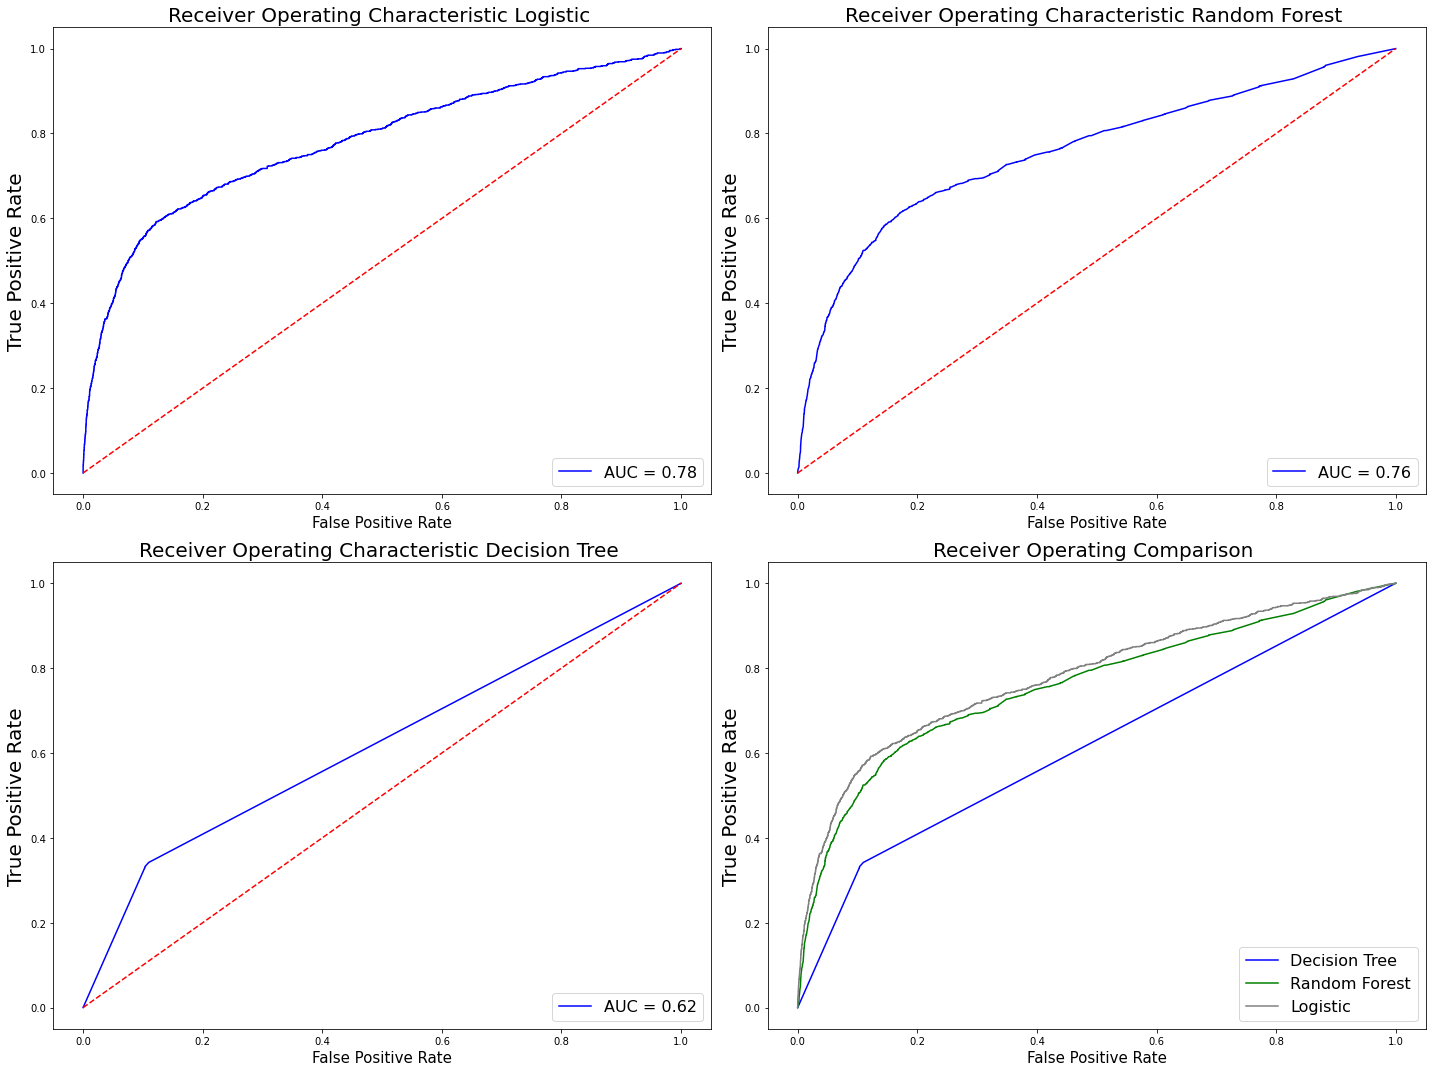

In [36]:
from sklearn import metrics
#fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 4))
fig, ax_arr = plt.subplots(nrows = 2, ncols = 2, figsize = (20,15))

#LOGMODEL
probs = logmodel.predict_proba(X_test)
preds = probs[:,1]
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test, preds)
roc_auclog = metrics.auc(fprlog, tprlog)

ax_arr[0,0].plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_auclog)
ax_arr[0,0].plot([0, 1], [0, 1],'r--')
ax_arr[0,0].set_title('Receiver Operating Characteristic Logistic ',fontsize=20)
ax_arr[0,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,0].legend(loc = 'lower right', prop={'size': 16})

#RANDOM FOREST --------------------
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
fprrfc, tprrfc, thresholdrfc = metrics.roc_curve(y_test, preds)
roc_aucrfc = metrics.auc(fprrfc, tprrfc)

ax_arr[0,1].plot(fprrfc, tprrfc, 'b', label = 'AUC = %0.2f' % roc_aucrfc)
ax_arr[0,1].plot([0, 1], [0, 1],'r--')
ax_arr[0,1].set_title('Receiver Operating Characteristic Random Forest ',fontsize=20)
ax_arr[0,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,1].legend(loc = 'lower right', prop={'size': 16})


#DECISION TREE ---------------------
probs = dtree.predict_proba(X_test)
preds = probs[:,1]
fprdtree, tprdtree, thresholddtree = metrics.roc_curve(y_test, preds)
roc_aucdtree = metrics.auc(fprdtree, tprdtree)

ax_arr[1,0].plot(fprdtree, tprdtree, 'b', label = 'AUC = %0.2f' % roc_aucdtree)
ax_arr[1,0].plot([0, 1], [0, 1],'r--')
ax_arr[1,0].set_title('Receiver Operating Characteristic Decision Tree ',fontsize=20)
ax_arr[1,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,0].legend(loc = 'lower right', prop={'size': 16})


#ALL PLOTS ----------------------------------

ax_arr[1,1].plot(fprdtree, tprdtree, 'b', label = 'Decision Tree', color='blue')
ax_arr[1,1].plot(fprrfc, tprrfc, 'b', label = 'Random Forest', color='green')
ax_arr[1,1].plot(fprlog, tprlog, 'b', label = 'Logistic', color='grey')
ax_arr[1,1].set_title('Receiver Operating Comparison ',fontsize=20)
ax_arr[1,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,1].legend(loc = 'lower right', prop={'size': 16})

plt.subplots_adjust(wspace=0.2)
plt.tight_layout() 

# Feature Selection

In [37]:
final_X_train = pd.DataFrame(data=X_train,columns=X.columns )
final_y_train = pd.DataFrame(data=y_train,columns=['y'])

In [38]:
from sklearn.svm import SVC


min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=LogisticRegression(solver='lbfgs', max_iter=1000),
    step=1,
    cv=k_fold,
    scoring="f1",
    min_features_to_select=min_features_to_select,
)

rfecv.fit(X_train, y_train)

# feature selection
print(rfecv.support_)
print(rfecv.ranking_)

[False  True  True False  True  True False  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[7 1 1 6 1 1 3 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 5 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [39]:
selected_columns = final_X_train.columns[rfecv.support_]
print(selected_columns.tolist())

['campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'job_blue-collar', 'job_other', 'job_pink-collar', 'job_self-employed', 'job_white-collar', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_no', 'default_unknown', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed']


In [40]:
X_train_final = final_X_train[selected_columns.tolist()]
y_train_final = final_y_train['y']

final_X_test = pd.DataFrame(data=X_test,columns=X.columns )
final_y_test = pd.DataFrame(data=y_test,columns=['y'])

X_test_final = final_X_test[selected_columns.tolist()]
y_test_final = final_y_test

X_test_final.head()

,campaign,pdays,emp.var.rate,cons.price.idx,euribor3m,job_blue-collar,job_other,job_pink-collar,job_self-employed,job_white-collar,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,-0.516871,0.36042,0.940101,0.818304,1.017895,-0.642208,-0.342506,3.454725,-0.211935,-0.620001,...,-0.16026,1.678884,-0.30587,-0.187593,-0.166323,2.550704,-0.409490,-0.42841,-0.408913,-0.40098
1,-0.078474,0.36042,1.114112,-0.047298,1.073970,1.557127,-0.342506,-0.289459,-0.211935,-0.620001,...,-0.16026,-0.595634,-0.30587,-0.187593,-0.166323,-0.392049,2.442064,-0.42841,-0.408913,-0.40098
2,0.359923,0.36042,0.940101,0.818304,1.016308,-0.642208,-0.342506,-0.289459,-0.211935,1.612900,...,-0.16026,1.678884,-0.30587,-0.187593,-0.166323,-0.392049,-0.409490,-0.42841,2.445511,-0.40098
3,-0.078474,0.36042,1.114112,0.698694,1.072383,1.557127,-0.342506,-0.289459,-0.211935,-0.620001,...,-0.16026,-0.595634,-0.30587,-0.187593,-0.166323,-0.392049,2.442064,-0.42841,-0.408913,-0.40098
4,1.236717,0.36042,-0.742005,-0.914475,-0.891301,1.557127,-0.342506,-0.289459,-0.211935,-0.620001,...,-0.16026,1.678884,-0.30587,-0.187593,-0.166323,2.550704,-0.409490,-0.42841,-0.408913,-0.40098


[[8962  170]
 [ 879  286]]
90.0


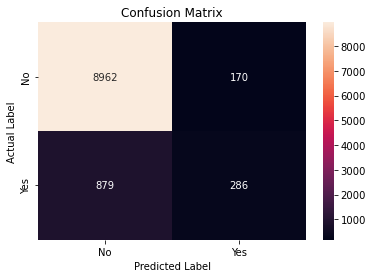

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9132
           1       0.63      0.25      0.35      1165

    accuracy                           0.90     10297
   macro avg       0.77      0.61      0.65     10297
weighted avg       0.88      0.90      0.88     10297



In [41]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression() 
logmodel.fit(X_train_final,y_train_final)
logpred = logmodel.predict(X_test_final)


print(confusion_matrix(y_test_final, logpred))
print(round(accuracy_score(y_test_final, logpred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train_final, y_train_final, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
import matplotlib.pyplot as plt
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(confusion_matrix(y_test_final, logpred), index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

from sklearn.metrics import confusion_matrix, classification_report
# Classification report
print(classification_report(y_test,logpred))

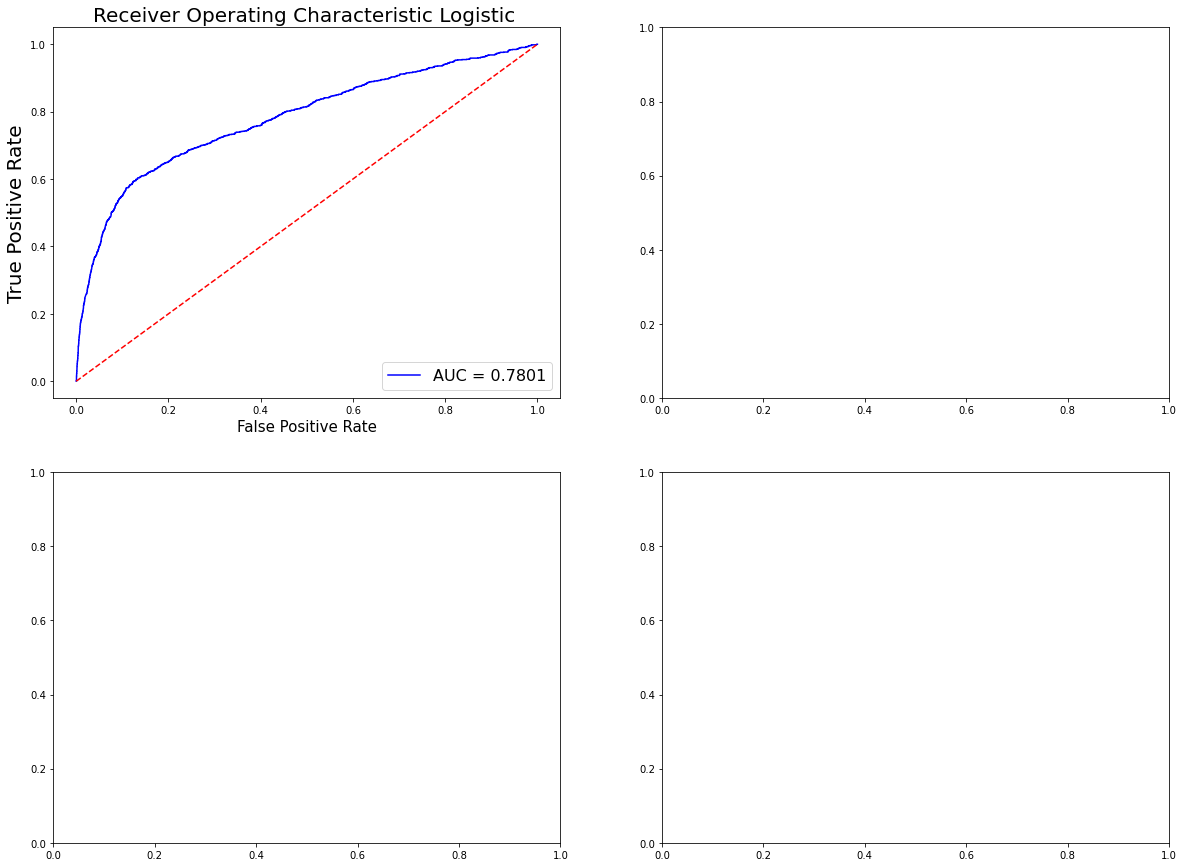

In [42]:
fig, ax_arr = plt.subplots(nrows = 2, ncols = 2, figsize = (20,15))

#LOGMODEL after feature selection
probs = logmodel.predict_proba(X_test_final)
preds = probs[:,1]
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test_final, preds)
roc_auclog = metrics.auc(fprlog, tprlog)

ax_arr[0,0].plot(fprlog, tprlog, 'b', label = 'AUC = %0.4f' % roc_auclog)
ax_arr[0,0].plot([0, 1], [0, 1],'r--')
ax_arr[0,0].set_title('Receiver Operating Characteristic Logistic ',fontsize=20)
ax_arr[0,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,0].legend(loc = 'lower right', prop={'size': 16})


In [43]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pday
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,True
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,True
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,True
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,True
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,0,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,True
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,0,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,True
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,0,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,True
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,0,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,True


## PCA

In [44]:
raw_data = df_data.drop(columns=['job', 'marital', 'education', 'default','housing','loan','poutcome','contact', 'month', 'day_of_week','y'])
from sklearn.preprocessing import StandardScaler
conv = StandardScaler()
std_data = conv.fit_transform( raw_data )

(41188, 5)
[43.26226209 15.072846   11.97306557 10.84081347  9.42944548]
[3.89369812 1.35658908 1.07760206 0.9756969  0.8486707 ]
the first 5 features could represent 91 percents of the viarance
0.9057843260007691


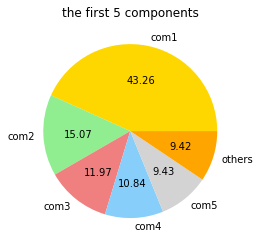

In [45]:
# use PCA to reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=5,svd_solver='full')
transformed_data = pca.fit_transform( std_data )
print( transformed_data.shape )
print( pca.explained_variance_ratio_*100 )
print( pca.explained_variance_ )

threshold = 0.80
for_test = 0
order = 0
for index,ratio in  enumerate (pca.explained_variance_ratio_):
    if threshold>for_test:
        for_test+= ratio
    else:
        order = index + 1
        break

print( 'the first %d features could represent 91 percents of the viarance' % order )
print( pca.explained_variance_ratio_[:order].sum() )
com_col = [ 'com'+str(i+1) for i in range(order) ]
com_col.append('others')
com_value = [ i for i in pca.explained_variance_ratio_[:order] ]
com_value.append( 1-pca.explained_variance_ratio_[:order].sum() )
com_colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightgrey', 'orange', 'white']
plt.figure( figsize=[4,4] )
plt.pie( x=com_value,labels=com_col,colors=com_colors,autopct='%.2f' )
plt.title( 'the first 5 components' )
plt.show()

In [46]:

principalDF = pd.DataFrame(data = transformed_data, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [47]:
pca.components_

array([[ 0.00158226, -0.09996454, -0.22733318,  0.30588652, -0.48824115,
        -0.36648842, -0.10162334, -0.49057881, -0.47018038],
       [ 0.25531994,  0.00502421, -0.63001528,  0.47775278,  0.16153094,
         0.27621339,  0.43058749,  0.14704789, -0.01430967],
       [-0.64456599,  0.30107641, -0.25195899,  0.27980001,  0.09263712,
         0.27902298, -0.51449312,  0.0040057 ,  0.03101003],
       [ 0.43186563,  0.88856888,  0.05177097, -0.02382878, -0.05829009,
        -0.03912306, -0.0941657 , -0.07178598, -0.04172088],
       [-0.57578411,  0.33100134,  0.00832975, -0.13067378, -0.07149475,
        -0.26101985,  0.68284515,  0.01356916, -0.04540115]])

In [48]:
pca.explained_variance_ratio_

array([0.43262262, 0.15072846, 0.11973066, 0.10840813, 0.09429445])

In [49]:
df_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,pink-collar,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,pink-collar,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,pink-collar,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,white-collar,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,pink-collar,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,other,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,other,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


In [50]:
principalDF

,PC1,PC2,PC3,PC4,PC5
0,-1.269177,0.884510,-1.486790,-0.036859,-0.657786
1,-1.269026,0.909010,-1.548642,0.004582,-0.713037
2,-1.272062,0.419006,-0.311605,-0.824245,0.391995
3,-1.271607,0.492506,-0.497160,-0.699921,0.226240
4,-1.269177,0.884510,-1.486790,-0.036859,-0.657786
...,...,...,...,...,...
41183,1.806778,-0.175653,-0.801034,1.279806,-3.857183
41184,1.802679,-0.837159,0.868967,0.160889,-2.365389
41185,1.768109,-0.590343,0.359141,0.896088,-2.798410
41186,1.802375,-0.886160,0.992671,0.078006,-2.254886


In [51]:
# Concatenation of dataframes
df_all = pd.concat([principalDF, df_data], axis=1)

<AxesSubplot:>

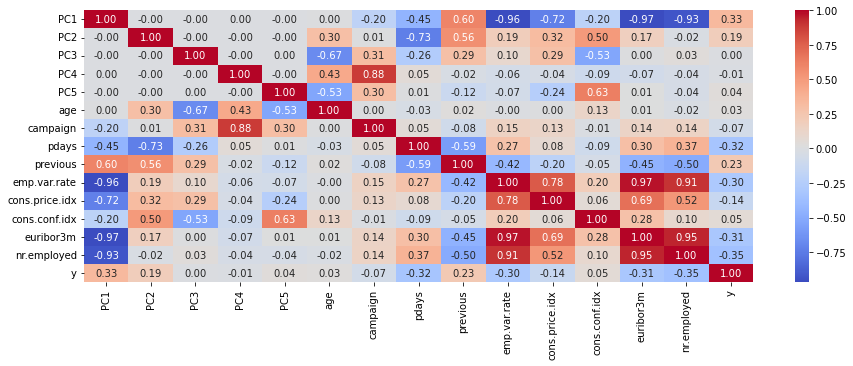

In [52]:
plt.figure(figsize=(15,5))
sns.heatmap(df_all.corr(), annot=True, fmt = ".2f", cmap = "coolwarm")

In [53]:
df_all.drop(columns=['age', 'campaign', 'pdays', 'previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m', 'nr.employed'], axis=1, inplace=True)

In [54]:
df_all

,PC1,PC2,PC3,PC4,PC5,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,-1.269177,0.884510,-1.486790,-0.036859,-0.657786,pink-collar,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,0
1,-1.269026,0.909010,-1.548642,0.004582,-0.713037,pink-collar,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,0
2,-1.272062,0.419006,-0.311605,-0.824245,0.391995,pink-collar,married,high.school,no,yes,no,telephone,may,mon,nonexistent,0
3,-1.271607,0.492506,-0.497160,-0.699921,0.226240,white-collar,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,0
4,-1.269177,0.884510,-1.486790,-0.036859,-0.657786,pink-collar,married,high.school,no,no,yes,telephone,may,mon,nonexistent,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1.806778,-0.175653,-0.801034,1.279806,-3.857183,other,married,professional.course,no,yes,no,cellular,nov,fri,nonexistent,1
41184,1.802679,-0.837159,0.868967,0.160889,-2.365389,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,nonexistent,0
41185,1.768109,-0.590343,0.359141,0.896088,-2.798410,other,married,university.degree,no,yes,no,cellular,nov,fri,nonexistent,0
41186,1.802375,-0.886160,0.992671,0.078006,-2.254886,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,nonexistent,1


In [55]:
# One-hot (creating dummies for categorical variables)
df_final = pd.get_dummies(df_all, columns=['job', 'marital', 'education', 'default','housing','loan','poutcome','contact', 'month', 'day_of_week'])

In [56]:
df_final.head()

,PC1,PC2,PC3,PC4,PC5,y,job_blue-collar,job_other,job_pink-collar,job_self-employed,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,-1.269177,0.884510,-1.486790,-0.036859,-0.657786,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,-1.269026,0.909010,-1.548642,0.004582,-0.713037,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2,-1.272062,0.419006,-0.311605,-0.824245,0.391995,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
3,-1.271607,0.492506,-0.497160,-0.699921,0.226240,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,-1.269177,0.884510,-1.486790,-0.036859,-0.657786,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0


In [57]:
# load X and y
X = df_final.drop(columns=['y'])
y = df_final['y']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)


[[9024  108]
 [ 935  230]]
90.0


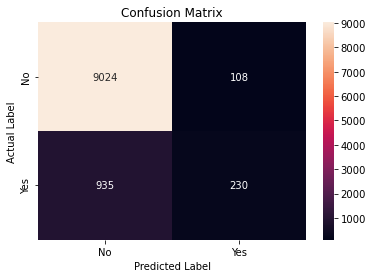

In [58]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
logpred = logmodel.predict(X_test)


print(confusion_matrix(y_test, logpred))
print(round(accuracy_score(y_test, logpred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
import matplotlib.pyplot as plt
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(confusion_matrix(y_test, logpred), index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

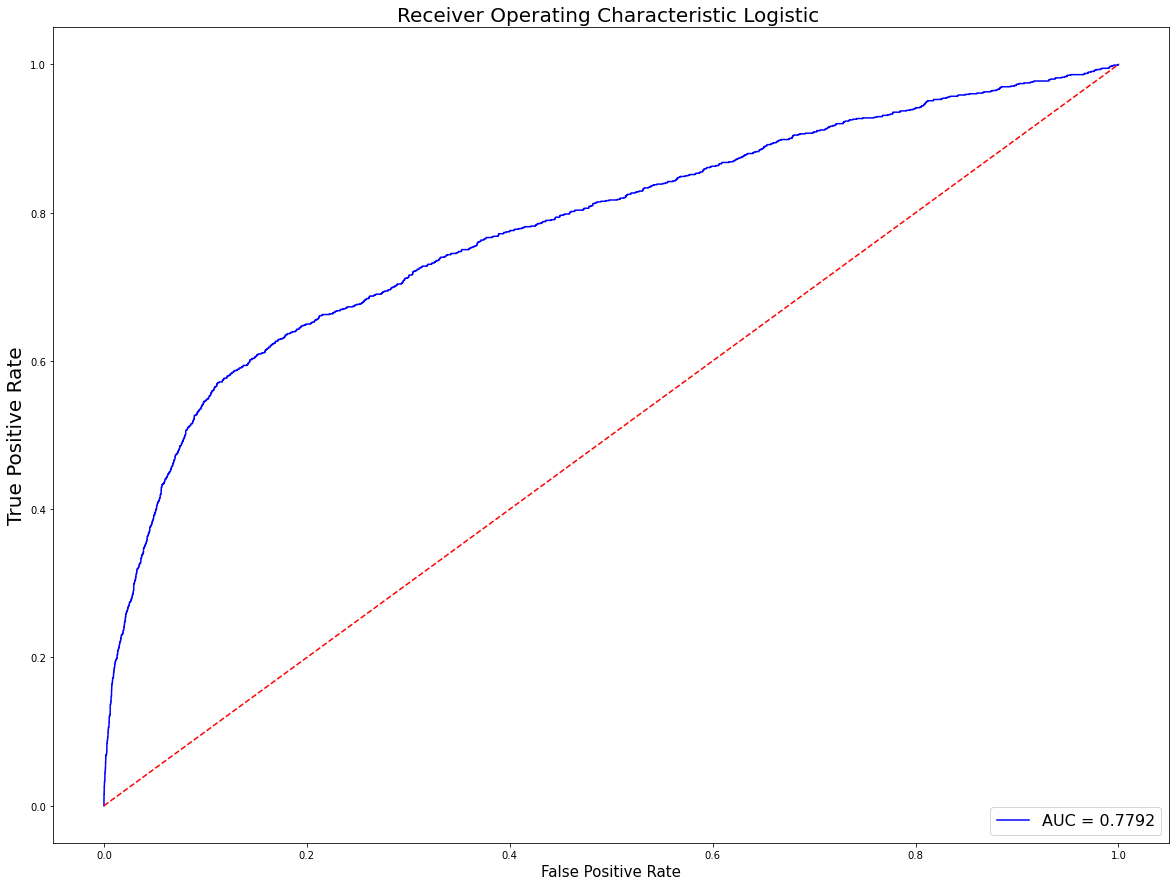

In [59]:
fig, ax_arr = plt.subplots(nrows = 1, ncols = 1, figsize = (20,15))

#LOGMODEL after feature selection
probs = logmodel.predict_proba(X_test)
preds = probs[:,1]
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test, preds)
roc_auclog = metrics.auc(fprlog, tprlog)

ax_arr.plot(fprlog, tprlog, 'b', label = 'AUC = %0.4f' % roc_auclog)
ax_arr.plot([0, 1], [0, 1],'r--')
ax_arr.set_title('Receiver Operating Characteristic Logistic ',fontsize=20)
ax_arr.set_ylabel('True Positive Rate',fontsize=20)
ax_arr.set_xlabel('False Positive Rate',fontsize=15)
ax_arr.legend(loc = 'lower right', prop={'size': 16})